# Remarques
* 
* 
* 

# Relevant imports

In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from string import digits
import pandas_profiling

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# ignore some warnings 
import warnings
warnings.filterwarnings('ignore')

# Load the data


In [335]:
#We load the data set into a pandas dataframe
data_to_learn = pd.read_excel('IPO_data_to_learn.xlsx')
data_to_predict = pd.read_excel('IPO_data_to_predict.xlsx')


# Add predictions 



In [343]:
data_to_learn['P1'] = data_to_learn.closeDay1 > data_to_learn.offerPrice


# Data cleaning

We clean the data to learn from, and we apply the same cleaning to the data to predict

In [344]:
data_to_learn.columns

Index(['closeDay1', 'offerPrice', 'rf', 'egc', 'html', 'patRatio', 'city',
       'issuer', 'highTech', 'age', 'exchange', 'year', 'industryFF5',
       'industryFF12', 'industryFF48', 'nUnderwriters', 'sharesOfferedPerc',
       'totalProceeds', 'manager', 'investmentReceived', 'amountOnProspectus',
       'commonEquity', 'sp2weeksBefore', 'nasdaq2weeksBefore',
       'dj2weeksBefore', 'blueSky', 'managementFee', 'commonEquity.1',
       'bookValue', 'totalAssets', 'totalRevenue', 'netIncome', 'roa',
       'leverage', 'vc', 'pe', 'prominence', 'nVCs', 'nExecutives',
       'priorFinancing', 'ipoSize', 'reputationLeadMax', 'reputationLeadAvg',
       'reputationSum', 'reputationAvg', 'nPatents', 'P1'],
      dtype='object')

In [338]:
data_to_learn.shape

(3330, 47)

**Below we see that the Unnamed_0 column represent some kind of indexing on the data which we don't need, hence it makes sence to drop that column.**

In [339]:
data_to_learn["Unnamed: 0"].unique().shape


(3330,)

In [340]:
data_to_learn.drop("Unnamed: 0", axis=1, inplace=True)
data_to_predict.drop("Unnamed: 0", axis=1, inplace=True)

**We decided to use pandas_profiling to output a full report of our dataset, we will then proceed to data cleaning accordingly**

In [189]:
data_to_learn.profile_report(style={'full_width':True})

In [240]:
profile = data_to_learn.profile_report(title='IPO data Profiling Report')
profile.to_file(output_file="data_profile.html")

## Correlation matrix

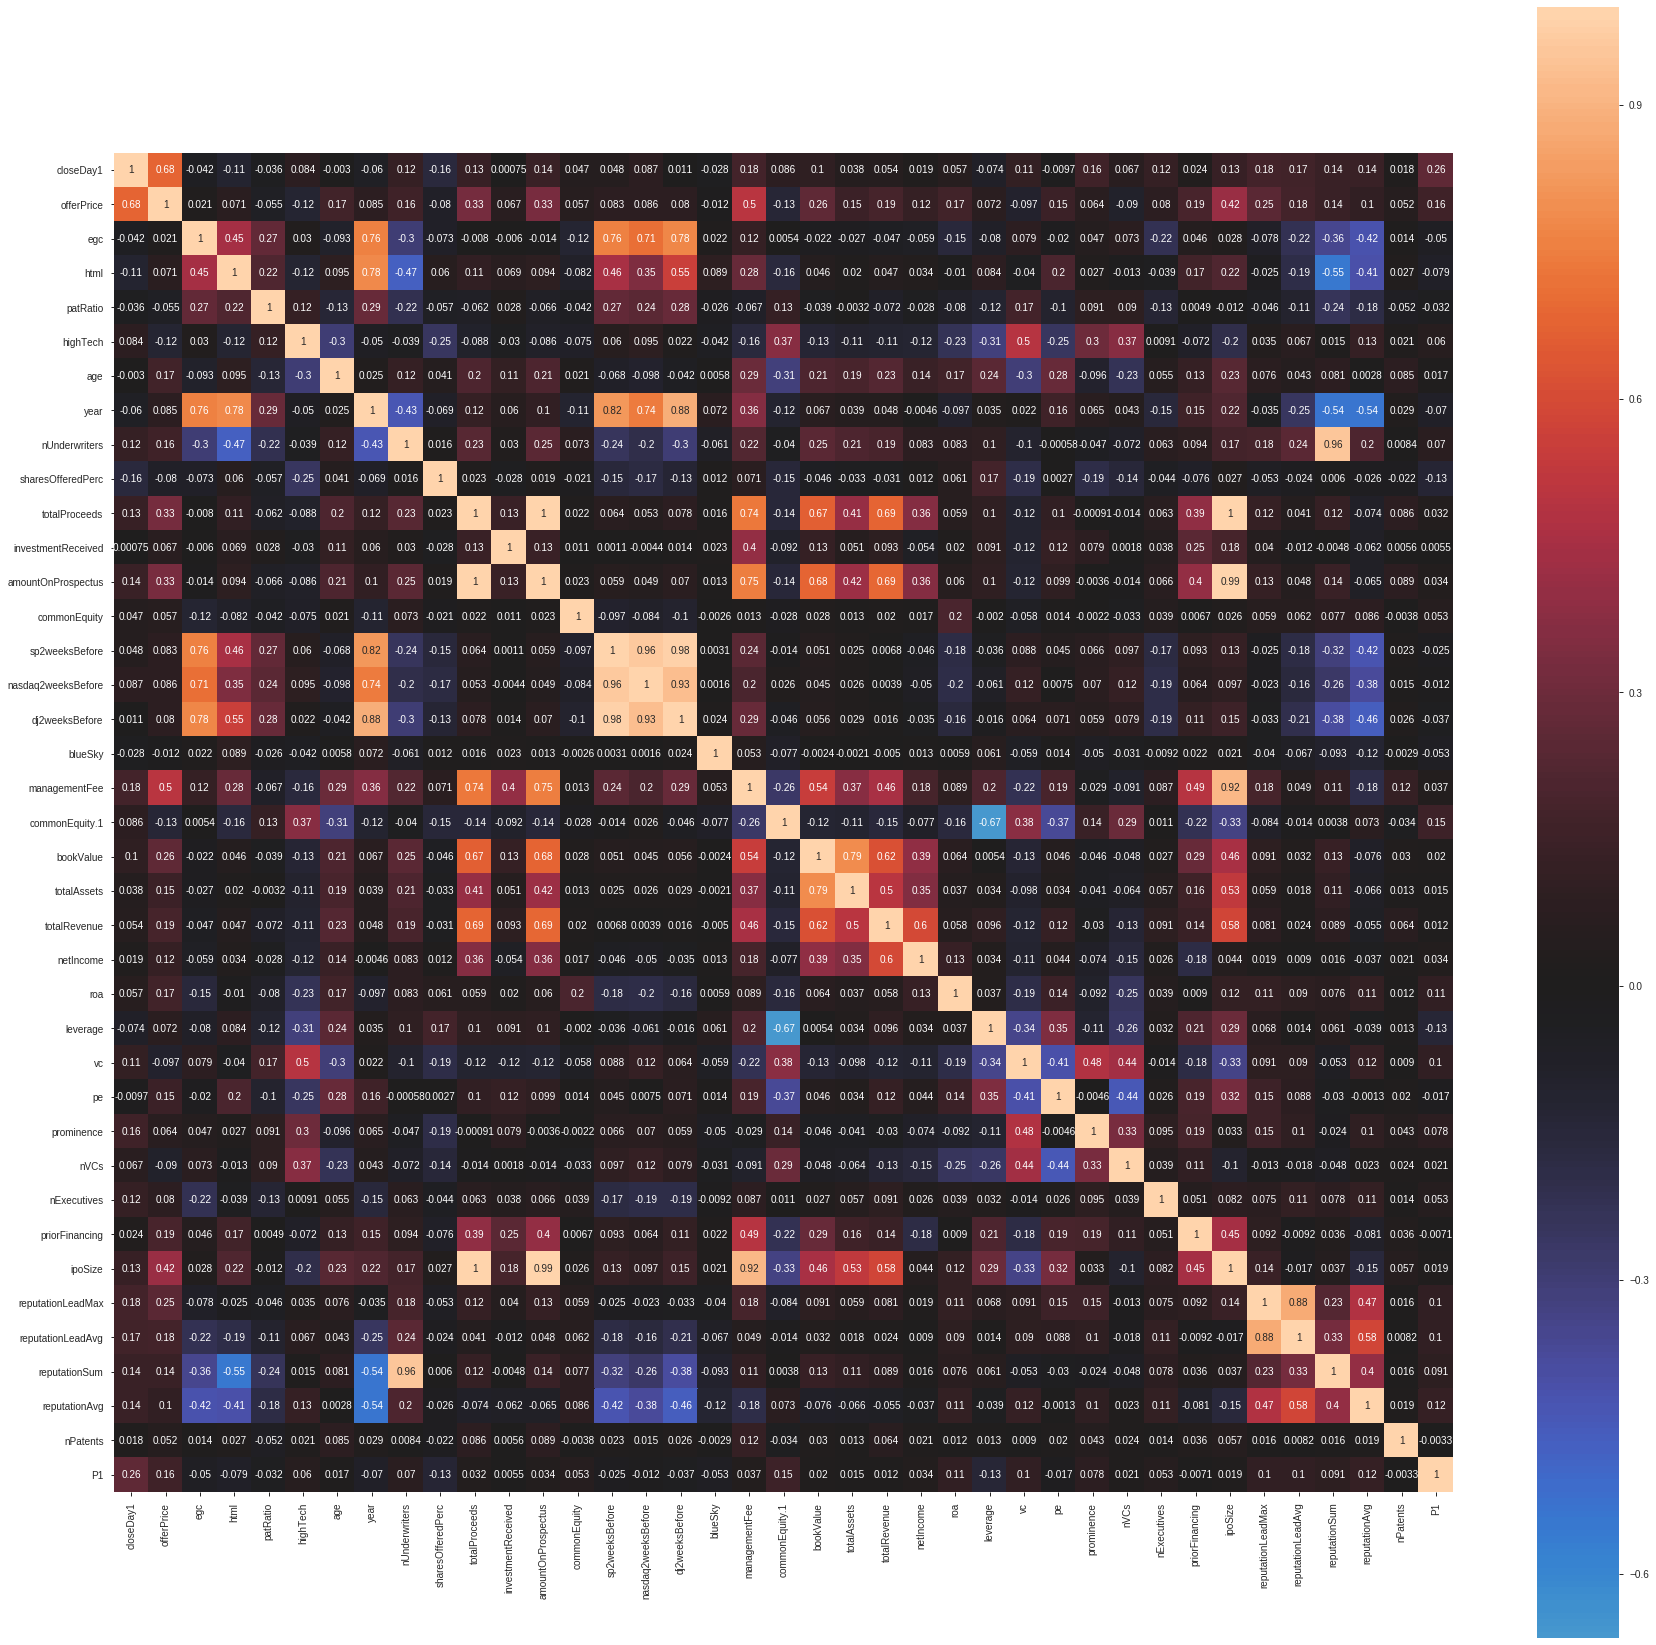

In [345]:
df = data_to_learn.corr()

plt.figure(figsize=(30,30))
sns.heatmap(data=df, xticklabels=df.columns, square=True, annot=True, center=0)

## I. Dropping highly correlated rows

We see from the correlation matrix the following interesting correlations:
- `ipoSize` and `totalProceeds` : 1.0
- `amountOnProspectus` and `totalProceeds`: 1.0
- `reputationSum` and `nUnderwriters`: 0.96

We choose to drop `ipoSize`, `amountOnProspectus` and `reputationSum`.

In [346]:
data_to_learn.drop(["ipoSize", "amountOnProspectus", 'reputationSum'], axis=1, inplace=True)
data_to_predict.drop(["ipoSize", "amountOnProspectus", 'reputationSum'], axis=1, inplace=True)

## II. Dealing with missing values

**Depending on the distribution of the variable, we replace missing values using the Mean or Variance: If the distribution is skewed or heavy tailed we use the median because it's more robust to outliers**

In [347]:
#For feature city we dropped the only record which had NaN because it also had NaN in other columns
data_to_learn.dropna(subset=['city'], inplace = True)
data_to_predict.dropna(subset=['city'], inplace = True)

In [348]:
# It made sence to give the value 0 to the missing values in leverage as it's the most common value 
#[https://www.thebalancesmb.com/how-leverage-can-benefit-your-business-398312]
data_to_learn['leverage'].fillna(value=0, inplace=True)
data_to_predict['leverage'].fillna(value=0, inplace=True)

In [349]:
#For feature blueSky, we replaced missing values by th evalue zero, 
#because in some states of the US there are no Blue Sky expenses.
#[https://www.colonialstock.com/blue-sky-state-filing-fees.htm]
data_to_learn['blueSky'].fillna(value=0, inplace=True)
data_to_predict['blueSky'].fillna(value=0, inplace=True)

In [350]:
#For features age, bookValue, investmentReceived, managementFee we used the median
values = {'age': data_to_learn["age"].median(),\
          'bookValue': data_to_learn["bookValue"].median(),\
          'investmentReceived': data_to_learn["investmentReceived"].median(),\
          'managementFee': data_to_learn["managementFee"].median(),\
          'commonEquity': data_to_learn["commonEquity"].median(),\
          'commonEquity.1': data_to_learn["commonEquity.1"].median(),\
          'investmentReceived': data_to_learn["investmentReceived"].median(),\
          'nExecutives': data_to_learn["nExecutives"].median(),\
          'netIncome': data_to_learn["netIncome"].median(),\
          'nVCs': data_to_learn["nVCs"].median(),\
          'patRatio': data_to_learn["patRatio"].median(),\
          'priorFinancing': data_to_learn["priorFinancing"].median(),\
          'roa': data_to_learn["roa"].median(),\
          'sharesOfferedPerc': data_to_learn["sharesOfferedPerc"].median(),\
          'totalAssets': data_to_learn["totalAssets"].median(),\
          'totalRevenue': data_to_learn["totalRevenue"].median()
         }

data_to_learn.fillna(value=values, inplace=True)
data_to_predict.fillna(value=values, inplace=True)

In [351]:
## closeDay1 is what we want to predict
## We drop the NaN values since it is akin to non-label data and they only represent 3% of the data

print("closeDay1 == NaN: ", data_to_learn.closeDay1.isna().sum())
print("closeDay1 == NaN: ", data_to_learn.closeDay1.isna().sum()/data_to_learn.closeDay1.shape[0]*100, '%')

data_to_learn = data_to_learn.dropna(subset=['closeDay1'])

closeDay1 == NaN:  115
closeDay1 == NaN:  3.4544908380895163 %


In [352]:
# replace NaN rf by empty string 

data_to_learn.fillna('', inplace=True)
data_to_predict.fillna('', inplace=True)

## II. Data Cleaning

First let's give our columns more meaningful names

In [353]:
data_to_learn.rename(columns={
    "commonEquity": "commonEquityPercentage",\
    "commonEquity.1": "commonEquity"
}, inplace=True)

### patRatio

We get rid of infinite values and set them to 0 since they correspond to (occurences of "patent" in the rf)/(length of rf)


In [354]:
data_to_learn.patRatio[data_to_learn.patRatio == np.inf].count()

data_to_learn.patRatio.replace(np.inf, 0.0, inplace=True)
data_to_predict.patRatio.replace(np.inf, 0.0, inplace=True)

### City
We clean the City feature: we remove numbers to avoid duplicates and leading and trailing whitespaces

In [355]:
# We remove numbers to avoid duplicates and leading and trailing whitespaces
data_to_learn["city"] = data_to_learn["city"].str.replace('\d+', '').str.strip()
data_to_predict["city"] = data_to_predict["city"].str.replace('\d+', '').str.strip()


### industryFF5, industryFF12, industryFF48

They are industry classifications with respectivelly 5, 12 and 48 categories.

We will label encode them 

In [226]:
data_to_learn.industryFF5.value_counts().shape

(5,)

In [227]:
data_to_learn.industryFF12.value_counts().shape

(12,)

In [228]:
data_to_learn.industryFF48.value_counts().shape

(48,)

In [229]:
# Hot-encode
data_to_learn = pd.get_dummies(data=data_to_learn, columns=['industryFF5', 'industryFF12', 'industryFF48'])
data_to_predict = pd.get_dummies(data=data_to_predict, columns=['industryFF5', 'industryFF12', 'industryFF48'])

### Exchange

The exchange is either `NASDQ`, `NYSE` or `ÀMEX`. 

We hot-encode it

In [230]:
data_to_learn.exchange.value_counts()

NASDQ    2288
NYSE      871
AMEX       55
Name: exchange, dtype: int64

In [231]:
# Hot-encode
data_to_learn = pd.get_dummies(data=data_to_learn, columns=['exchange'])
data_to_predict = pd.get_dummies(data=data_to_predict, columns=['exchange'])

### Issuer

`issuer` is unique. We assume it therefore gives no predictive value and we drop it.

In [356]:
data_to_learn.issuer.is_unique

True

In [357]:
data_to_learn.drop(["issuer"], axis=1, inplace=True)
data_to_predict.drop(["issuer"], axis=1, inplace=True)

### Process `manager`

- Add columns with the amount of managers (maybe it's useful)

---

- Create a corpus where each document is a `manager` entry (1)
- Compute the TF-IDF representation of each of those documents
- Compute the **average cosine-similarity** between **each** document's TF-IDF representation and **all** the TF-IDF representations of the **successful** IPO
- Store this average in your dataset

When a new document appears:
- Compute the TF-IDF of this new document (using (1) as corpus)
- Compute the **average cosine-similarity** of your new document's TF-IDF representation and **all** the TF-IDF representations of the **successful** IPO
- Store this average in your dataset



In [358]:
data_to_learn.manager.head()


0                      Credit Suisse First Boston Corp
1                                         Stephens Inc
2    Bank of America Merrill Lynch\nGoldman Sachs &...
3                                 CS First Boston Corp
4    Cowen & Co\nPiper Jaffray Cos\nJMP Securities LLC
Name: manager, dtype: object

In [359]:
data_to_learn.to_pickle('data_to_learn.pkl')
data_to_predict.to_pickle('data_to_predict.pkl')

In [360]:
data_to_learn = pd.read_pickle('data_to_learn.pkl')
data_to_predict = pd.read_pickle('data_to_predict.pkl')

In [361]:
data_to_learn['managerAmount'] = data_to_learn.manager.apply(lambda x: len(x.split('\n')))
data_to_predict['managerAmount'] = data_to_predict.manager.apply(lambda x: len(x.split('\n')))

data_to_learn.manager = data_to_learn.manager.apply(lambda x: x.replace('\n', ' '))
data_to_predict.manager = data_to_predict.manager.apply(lambda x: x.replace('\n', ' '))

In [362]:
# Compute the TF-IDF score of each rf entry
tf_idf_vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=0)
tf_idf_vectorizer.fit(data_to_learn.manager)
tf_idf_matrix = tf_idf_vectorizer.transform(data_to_learn.manager)

In [363]:
# List the index where the IPO is successful
successful_index = []
for i, is_successful in enumerate(y):
    if is_successful:
        successful_index.append(i)

In [364]:
# Compute the **average cosine-similarity** between **each** document's TF-IDF representation and **all** the TF-IDF representations of the **successful** IPO
cosine_similarities_series = pd.Series()
for i in range(len(data_to_learn.manager)):
    cosine_similarities = linear_kernel(tf_idf_matrix[i], tf_idf_matrix[successful_index]).flatten()
    cosine_similarities_series.loc[i] = cosine_similarities.mean()
    
data_to_learn['cosineSimilarityManager'] = cosine_similarities_series

In [365]:
# Compute the **average cosine-similarity** between **each** document's TF-IDF representation and **all** the TF-IDF representations of the **successful** IPO
cosine_similarities_series = pd.Series()
for i in range(len(data_to_predict.manager)):
    cosine_similarities = linear_kernel(tf_idf_vectorizer.transform(data_to_predict.manager[i:i+1]), tf_idf_matrix[successful_index]).flatten()
    cosine_similarities_series.loc[i] = cosine_similarities.mean()
    
data_to_predict['cosineSimilarityManager'] = cosine_similarities_series

In [366]:
data_to_learn.drop('manager', axis=1, inplace=True)
data_to_predict.drop('manager', axis=1, inplace=True)

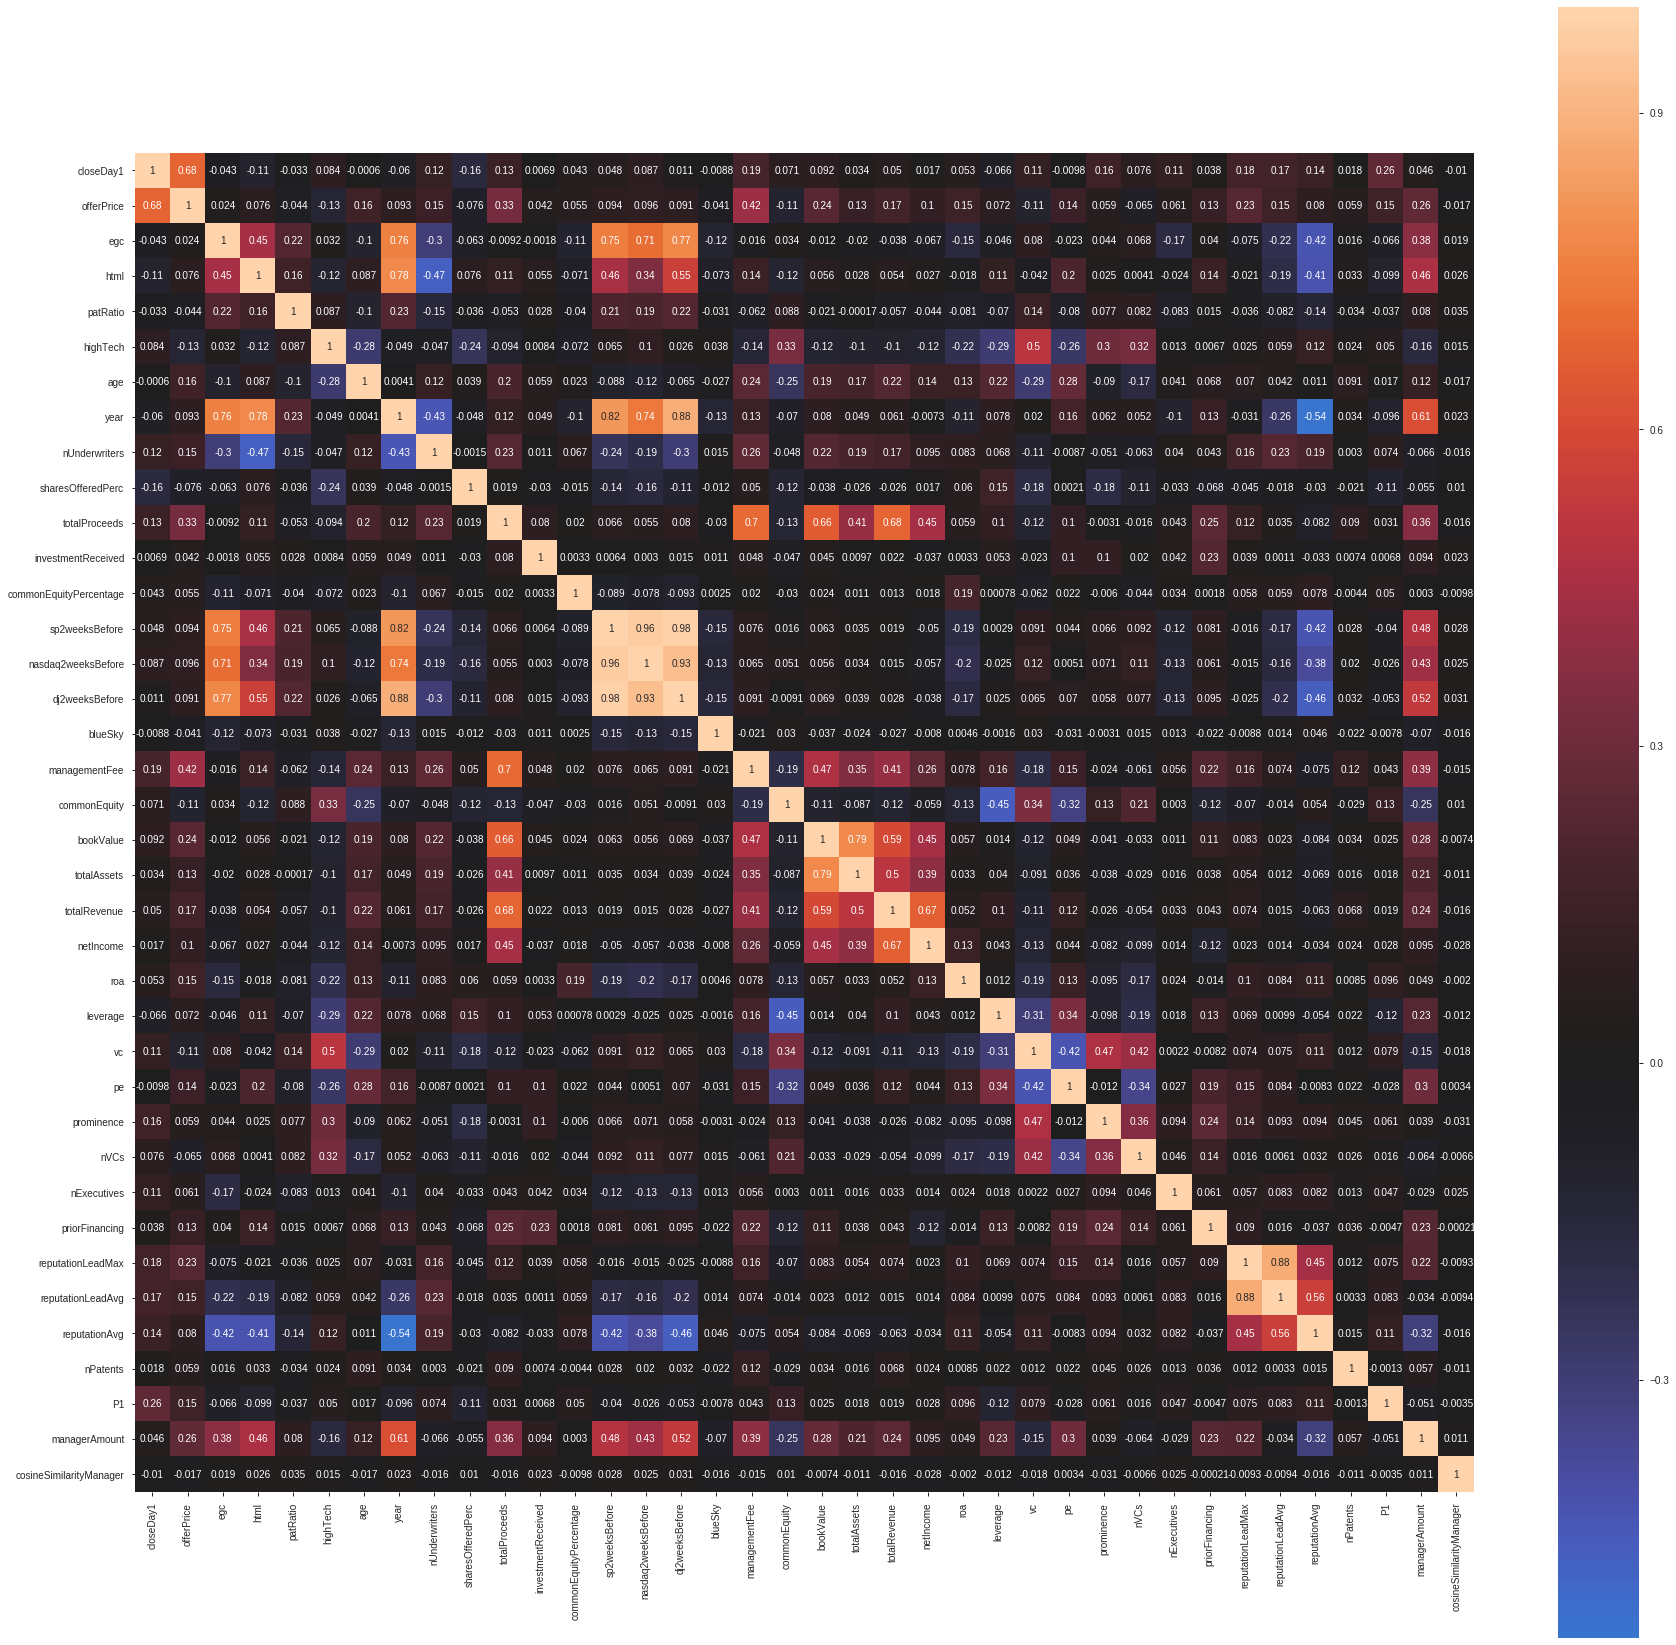

In [367]:
df = data_to_learn.corr()

plt.figure(figsize=(30,30))
sns.heatmap(data=df, xticklabels=df.columns, square=True, annot=True, center=0)

### rf
We should also clean the risk factor section of the data

In [42]:
import re 
import spacy
import nltk
from nltk import corpus

stopwords = set(corpus.stopwords.words('english'))

def clean_re(txt):
    return re.sub(r'[^\w\s]', '', txt) # We get rid of (non-words, non-whitespaces)

def remove_stopwords(txt):
    removed_txt = []
    for token in txt.split():
        if not token in stopwords:
            removed_txt.append(token)
    return ' '.join(removed_txt)

def lemmatize_text(txt):
    wnl = nltk.stem.WordNetLemmatizer() # maybe use a better lemmatizer eventually 
    
    lemmatized_txt = []
    for token in txt.split():
        lemmatized_txt.append(wnl.lemmatize(token))
    return ' '.join(lemmatized_txt).strip()

def preprocess_text(txt):
    txt = clean_re(txt)
    txt = remove_stopwords(txt.lower())
    txt = lemmatize_text(txt)
    return txt

In [43]:
data_to_learn.rf = data_to_learn.rf.apply(preprocess_text)
data_to_predict.rf = data_to_predict.rf.apply(preprocess_text)


## III. Dealing with outliers

In [579]:
#Can be done in EDA as well

# Exploratory Data Analysis

# ML


In [275]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import GradientBoostingClassifier

from sklearn.pipeline        import Pipeline
from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import roc_auc_score
from sklearn.metrics         import roc_curve


SEED = 1

In [276]:
prediction_labels = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9']
X_to_predict = data_to_predict[list(set(data_to_predict.columns) - set(prediction_labels))]


## Prediction P1

- Predict whether the **closing price at the end of the first day** (i.e. `closeDay1`) of trading will go up (the "positive" case, coded as 1) or down (the "negative" case, coded as 0) from the **offer price** `offerPrice`. You may use all data from the dataset except for the rf variable (i.e., risk factors).


### Preliminary

We want to predict whether the offer price is **underpriced** or **overpriced**.

The **label to predict** is **"Is offer price underpriced ?"**. 

Therefore, 
- **False Positives** are especially **costly**, (we would actually lose money) 
- **False Negatives are not costly** (we would simply miss an opportunity to make money) 
- **True Positives** make us money 
- **True Negatives** avoid us losing money.

Let's use the AUC

In [277]:
# Prepare the dataset to learn from
y = data_to_learn['closeDay1'] > data_to_learn['offerPrice']

X = data_to_learn.drop(['closeDay1', 'rf'], axis=1)

# For now, we discard the city, the managers and issuer. Later, hot-encode or something
X.drop(['city', 'manager', 'issuer'], axis=1, inplace=True)


## Split into test, train, validation sets

From the data to train from, 20% is test set, 20% is train set and 20% is test set

In [278]:
# We start by extracting our test set (20% of all data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED, stratify=y)

# We then divide our initial training set into our actual training set and our validation set (20%)
X_train_train, X_train_val, y_train_train, y_train_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED, stratify=y_train)

### KNN

In [279]:
# Build pipeline
steps = []
steps.append(('standardize', StandardScaler()))
steps.append(('knn_model', KNeighborsClassifier()))
pipeline = Pipeline(steps)

Max AUC with K:  10    51
Name: K, dtype: int64


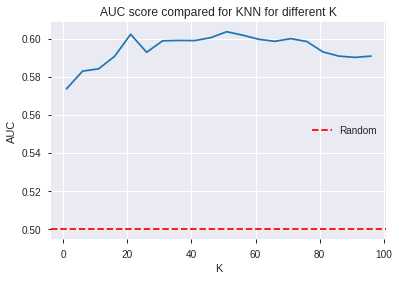

In [280]:
# Tune K
results = []
for k in range(1, 100, 5):
    pipeline.set_params(knn_model__n_neighbors=k) 
    pipeline.fit(X_train_train, y_train_train)
    y_train_val_hat_prob = pipeline.predict_proba(X_train_val)[:,1]
    auc = roc_auc_score(y_train_val, y_train_val_hat_prob)
    results.append((auc, k))

# View results 
results = pd.DataFrame(results)
results.columns = ['AUC', 'K']
sns.lineplot(x='K', y='AUC', data=results)
plt.axhline(y=0.5, c='r', linestyle='--', label='Random')
plt.legend()
plt.title('AUC score compared for KNN for different K')
print('Max AUC with K: ', results[results.AUC == results.AUC.max()].K)

### Random Forest

In [281]:
# Build pipeline
steps = []
steps.append(('forest_model', RandomForestClassifier(random_state=SEED)))
pipeline = Pipeline(steps)

Max AUC with N:  8    41
Name: N, dtype: int64


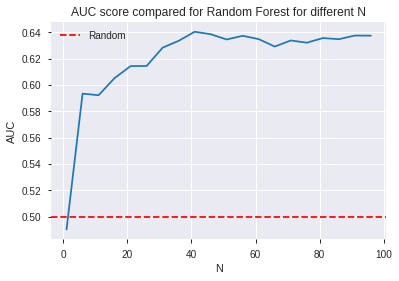

In [282]:
# Tune N   
results = []
for n in range(1, 100, 5):
    pipeline.set_params(forest_model__n_estimators = n) 
    pipeline.fit(X_train_train, y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)
    auc = roc_auc_score(y_train_val, y_train_pred[:,1])
    results.append( (auc, n))

# View results 
results = pd.DataFrame(results)
results.columns = ['AUC', 'N']
sns.lineplot(x='N', y='AUC', data=results)
plt.axhline(y=0.5, c='r', linestyle='--', label='Random')
plt.legend()
plt.title('AUC score compared for Random Forest for different N')
print('Max AUC with N: ', results[results.AUC == results.AUC.max()].N)

## Prediction P2

- Predict whether the **closing price at the end of the first day** of trading will go up (the "positive" case, coded as 1) or down (the "negative" case, coded as 0) from the **offer price.** You may use only the **rf** (i.e., risk factors), **year**, and **industryFF12** variables for this prediction task. You may, however, perform additional text analysis of the rf variable.


In [45]:
# Prepare the dataset to learn from
y = data_to_learn['closeDay1'] > data_to_learn['offerPrice']


X = data_to_learn[['rf', 'year'] + [industryFF12_column for industryFF12_column in data_to_learn.columns if industryFF12_column.startswith('industry')]]

In [46]:
X.head()

rf  year  \
0  risk factor carefully consider following risk ...  2000   
1  risk factor investment common stock involves r...  2006   
2  risk factor investing common stock involves hi...  2013   
3  risk factor carefully consider following risk ...  1999   
4  risk factor investing common stock involves hi...  2016   

   industryFF5_Business Equipment, Telephone and Television Transmission  \
0                                                  1                       
1                                                  0                       
2                                                  0                       
3                                                  1                       
4                                                  0                       

   industryFF5_Consumer Durables, NonDurables, Wholesale, Retail, and Some Services (Laundries, Repair Shops)  \
0                                                  0                                                            
1                                                  0                                                            
2                                                  0                                                            
3                                                  0                                                            
4                                                  0                                                            

   industryFF5_Healthcare, Medical Equipment, and Drugs  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  1      

   industryFF5_Manufacturing, Energy, and Utilities  industryFF5_Other  \
0                                                 0                  0   
1                                                 0                  1   
2                                                 0                  1   
3                                                 0                  0   
4                                                 0                  0   

   industryFF12_Business Equipment -- Computers, Software, and Electronic Equipment  \
0                                                  1                                  
1                                                  0                                  
2                                                  0                                  
3                                                  1                                  
4                                                  0                                  

   industryFF12_Chemicals and Allied Products  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   industryFF12_Consumer Durables -- Cars, TV's, Furniture, Household Appliances  \
0                                                  0                               
1                                                  0                               
2                                                  0                               
3                                                  0                               
4                                                  0                               

   ...  industryFF48_Rubber and Plastic Products  \
0  ...                                         0   
1  ...                                         0   
2  ...                                         0   
3  ...                                         0   
4  ...                                         0   

   industryFF48_Shipbuilding, Railroad Equipment  \
0                                              0   
1

### Process `rf`

- Store `rf` length 

---

- Create a corpus where each document is a `rf` entry (1)
- Compute the TF-IDF representation of each of those documents
- Compute the **average cosine-similarity** between **each** document's TF-IDF representation and **all** the TF-IDF representations of the **successful** IPO
- Store this average in your dataset




When a new document appears:
- Compute the TF-IDF of this new document (using (1) as corpus)
- Compute the **average cosine-similarity** of your new document's TF-IDF representation and **all** the TF-IDF representations of the **successful** IPO
- Store this average in your dataset


Mean rf word length:  2522.8705662725574
Std rf word length:  812.2016548956552


Text(0, 0.5, 'Occurences')

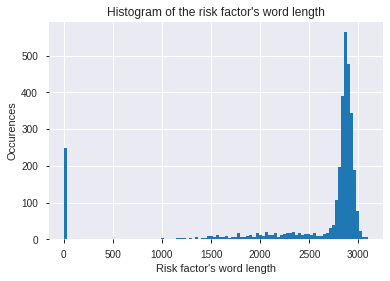

In [58]:
df = data_to_learn.rf.apply(lambda x: len(x.split()))
df.hist(bins=100)
print("Mean rf word length: ", df.mean())
print("Std rf word length: ", df.std())
plt.title("Histogram of the risk factor's word length")
plt.xlabel("Risk factor's word length")
plt.ylabel("Occurences")

In [82]:
X['rfLength'] = X.rf.apply(lambda x: len(x.split()))

In [127]:
# Compute the TF-IDF score of each rf entry
tf_idf_vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=0)
tf_idf_vectorizer.fit(X.rf)
tf_idf_matrix = tf_idf_vectorizer.transform(X.rf)

KeyboardInterrupt: 

In [ ]:
# List the index where the IPO is successful
successful_index = []
for i, is_successful in enumerate(range(len(y))):
    if is_successful:
        successful_index.append(i)
        

In [ ]:
# Compute the **average cosine-similarity** between **each** document's TF-IDF representation and **all** the TF-IDF representations of the **successful** IPO
cosine_similarity_rf = pd.DataFrame(columns=['cosine_similarity_rf'])
for i in range(len(X.rf)):
    cosine_similarities = linear_kernel(tf_idf_matrix[i], tf_idf_matrix[successful_index]).flatten()
    cosine_similarity = np.delete(cosine_similarities, i)
    cosine_similarity_rf.loc[i] = cosine_similarities.mean()
    
X['cosineSimilarityRf'] = cosine_similarity_rf